<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Maximum Likelihood Estimation

## Contents

- [Maximum Likelihood Estimation](#Maximum-Likelihood-Estimation)  
  - [Overview](#Overview)  
  - [Set Up and Assumptions](#Set-Up-and-Assumptions)  
  - [Conditional Distributions](#Conditional-Distributions)  
  - [Maximum Likelihood Estimation](#Maximum-Likelihood-Estimation)  
  - [MLE with Numerical Methods](#MLE-with-Numerical-Methods)  
  - [Maximum Likelihood Estimation with `statsmodels`](#Maximum-Likelihood-Estimation-with-`statsmodels`)  
  - [Summary](#Summary)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

In a [previous lecture](https://python-programming.quantecon.org/ols.html), we estimated the relationship between
dependent and explanatory variables using linear regression.

But what if a linear relationship is not an appropriate assumption for our model?

One widely used alternative is maximum likelihood estimation, which
involves specifying a class of distributions, indexed by unknown parameters, and then using the data to pin down these parameter values.

The benefit relative to linear regression is that it allows more flexibility in the probabilistic relationships between variables.

Here we illustrate maximum likelihood by replicating Daniel Treisman’s (2016) paper, [Russia’s Billionaires](http://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068), which connects the number of billionaires in a country to its economic characteristics.

The paper concludes that Russia has a higher number of billionaires than
economic factors such as market size and tax rate predict.

We’ll require the following imports:

In [2]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

### Prerequisites

We assume familiarity with basic probability and multivariate calculus.

## Set Up and Assumptions

Let’s consider the steps we need to go through in maximum likelihood estimation and how they pertain to this study.

### Flow of Ideas

The first step with maximum likelihood estimation is to choose the probability distribution believed to be generating the data.

More precisely, we need to make an assumption as to which *parametric class* of distributions is generating the data.

- e.g., the class of all normal distributions, or the class of all gamma distributions.  


Each such class is a family of distributions indexed by a finite number of parameters.

- e.g., the class of normal distributions is a family of distributions
  indexed by its mean $ \mu \in (-\infty, \infty) $ and standard deviation $ \sigma \in (0, \infty) $.  


We’ll let the data pick out a particular element of the class by pinning down the parameters.

The parameter estimates so produced will be called **maximum likelihood estimates**.

### Counting Billionaires

Treisman [[Tre16]](https://python-programming.quantecon.org/zreferences.html#treisman2016) is interested in estimating the number of billionaires in different countries.

The number of billionaires is integer-valued.

Hence we consider distributions that take values only in the nonnegative integers.

(This is one reason least squares regression is not the best tool for the present problem, since the dependent variable in linear regression is not restricted
to integer values)

One integer distribution is the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), the probability mass function (pmf) of which is

$$
f(y) = \frac{\mu^{y}}{y!} e^{-\mu},
\qquad y = 0, 1, 2, \ldots, \infty
$$

We can plot the Poisson distribution over $ y $ for different values of $ \mu $ as follows

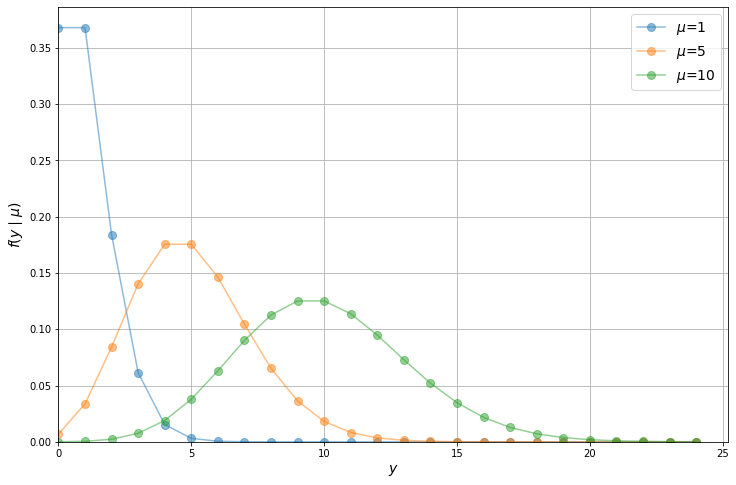

In [3]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

Notice that the Poisson distribution begins to resemble a normal distribution as the mean of $ y $ increases.

Let’s have a look at the distribution of the data we’ll be working with in this lecture.

Treisman’s main source of data is *Forbes’* annual rankings of billionaires and their estimated net worth.

The dataset `mle/fp.dta` can be downloaded <a href=/_static/lecture_specific/mle/fp.dta download>here</a>
or from its [AER page](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068).

In [4]:
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


Using a histogram, we can view the distribution of the number of
billionaires per country, `numbil0`, in 2008 (the United States is
dropped for plotting purposes)

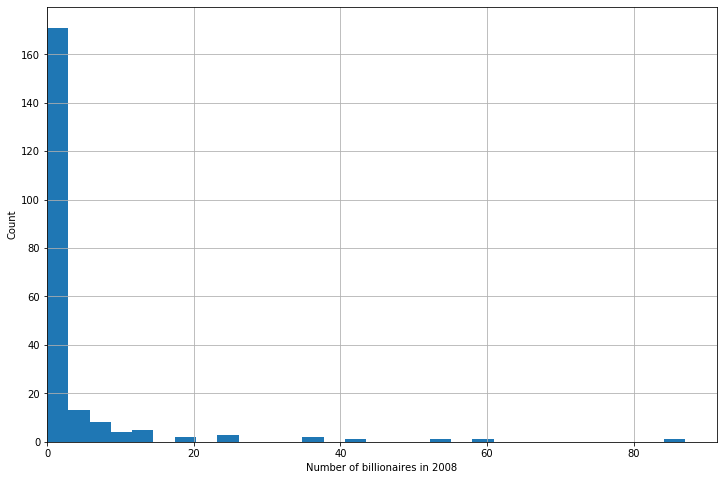

In [5]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

From the histogram, it appears that the Poisson assumption is not unreasonable (albeit with a very low $ \mu $ and some outliers).

## Conditional Distributions

In Treisman’s paper, the dependent variable — the number of billionaires $ y_i $ in country $ i $ — is modeled as a function of GDP per capita, population size, and years membership in GATT and WTO.

Hence, the distribution of $ y_i $ needs to be conditioned on the vector of explanatory variables $ \mathbf{x}_i $.

The standard formulation — the so-called *poisson regression* model — is as follows:


<a id='equation-poissonreg'></a>
$$
f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty . \tag{1}
$$

$$
\text{where}\ \mu_i
     = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
$$

To illustrate the idea that the distribution of $ y_i $ depends on
$ \mathbf{x}_i $ let’s run a simple simulation.

We use our `poisson_pmf` function from above and arbitrary values for
$ \boldsymbol{\beta} $ and $ \mathbf{x}_i $

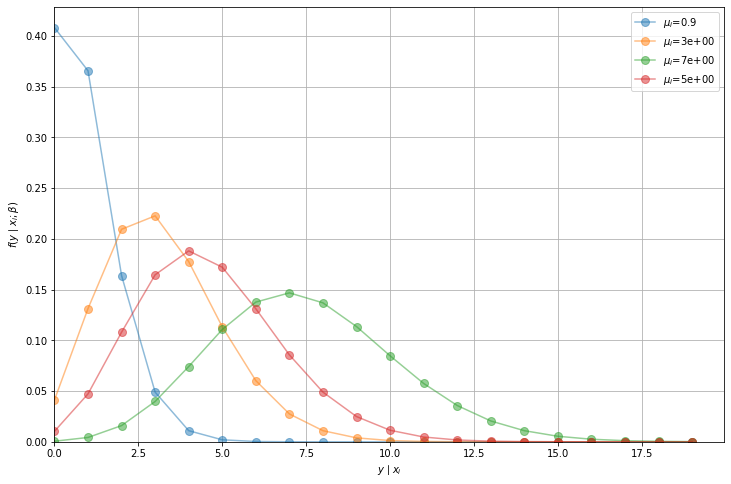

In [6]:
y_values = range(0, 20)

# Define a parameter vector with estimates
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

for X in datasets:
    μ = exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

We can see that the distribution of $ y_i $ is conditional on
$ \mathbf{x}_i $ ($ \mu_i $ is no longer constant).

## Maximum Likelihood Estimation

In our model for number of billionaires, the conditional distribution
contains 4 ($ k = 4 $) parameters that we need to estimate.

We will label our entire parameter vector as $ \boldsymbol{\beta} $ where

$$
\boldsymbol{\beta} = \begin{bmatrix}
                            \beta_0 \\
                            \beta_1 \\
                            \beta_2 \\
                            \beta_3
                      \end{bmatrix}
$$

To estimate the model using MLE, we want to maximize the likelihood that
our estimate $ \hat{\boldsymbol{\beta}} $ is the true parameter $ \boldsymbol{\beta} $.

Intuitively, we want to find the $ \hat{\boldsymbol{\beta}} $ that best fits our data.

First, we need to construct the likelihood function $ \mathcal{L}(\boldsymbol{\beta}) $, which is similar to a joint probability density function.

Assume we have some data $ y_i = \{y_1, y_2\} $ and
$ y_i \sim f(y_i) $.

If $ y_1 $ and $ y_2 $ are independent, the joint pmf of these
data is $ f(y_1, y_2) = f(y_1) \cdot f(y_2) $.

If $ y_i $ follows a Poisson distribution with $ \lambda = 7 $,
we can visualize the joint pmf like so

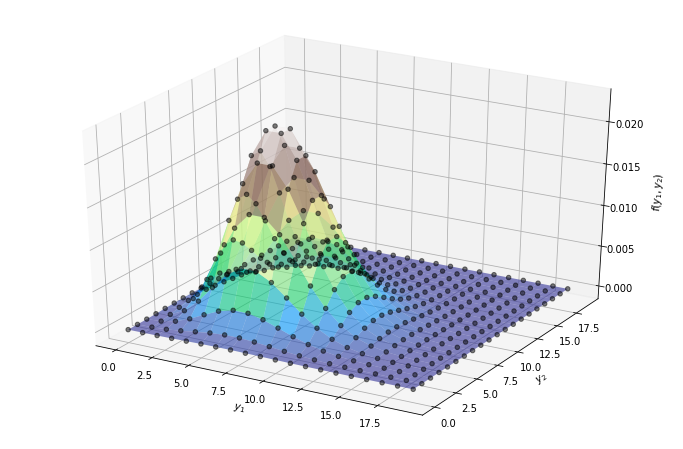

In [7]:
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

Similarly, the joint pmf of our data (which is distributed as a
conditional Poisson distribution) can be written as

$$
f(y_1, y_2, \ldots, y_n \mid \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n; \boldsymbol{\beta})
    = \prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}
$$

$ y_i $ is conditional on both the values of $ \mathbf{x}_i $ and the
parameters $ \boldsymbol{\beta} $.

The likelihood function is the same as the joint pmf, but treats the
parameter $ \boldsymbol{\beta} $ as a random variable and takes the observations
$ (y_i, \mathbf{x}_i) $ as given

$$
\begin{split}
\mathcal{L}(\beta \mid y_1, y_2, \ldots, y_n \ ; \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n) = &
\prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i} \\ = &
f(y_1, y_2, \ldots, y_n \mid  \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n ; \beta)
\end{split}
$$

Now that we have our likelihood function, we want to find the $ \hat{\boldsymbol{\beta}} $ that yields the maximum likelihood value

$$
\underset{\boldsymbol{\beta}}{\max} \mathcal{L}(\boldsymbol{\beta})
$$

In doing so it is generally easier to maximize the log-likelihood (consider
differentiating $ f(x) = x \exp(x) $  vs.  $ f(x) = \log(x) + x $).

Given that taking a logarithm is a monotone increasing transformation, a maximizer of the likelihood function will also be a maximizer of the log-likelihood function.

In our case the log-likelihood is

$$
\begin{split}
\log{ \mathcal{L}} (\boldsymbol{\beta}) = \ &
    \log \Big(
        f(y_1 ; \boldsymbol{\beta})
        \cdot
        f(y_2 ; \boldsymbol{\beta})
        \cdot \ldots \cdot
        f(y_n ; \boldsymbol{\beta})
        \Big) \\
        = &
        \sum_{i=1}^{n} \log{f(y_i ; \boldsymbol{\beta})} \\
        = &
        \sum_{i=1}^{n}
        \log \Big( {\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}} \Big) \\
        = &
        \sum_{i=1}^{n} y_i \log{\mu_i} -
        \sum_{i=1}^{n} \mu_i -
        \sum_{i=1}^{n} \log y!
\end{split}
$$

The MLE of the Poisson to the Poisson  for $ \hat{\beta} $ can be obtained by solving

$$
\underset{\beta}{\max} \Big(
\sum_{i=1}^{n} y_i \log{\mu_i} -
\sum_{i=1}^{n} \mu_i -
\sum_{i=1}^{n} \log y! \Big)
$$

However, no analytical solution exists to the above problem – to find the MLE
we need to use numerical methods.

## MLE with Numerical Methods

Many distributions do not have nice, analytical solutions and therefore require
numerical methods to solve for parameter estimates.

One such numerical method is the Newton-Raphson algorithm.

Our goal is to find the maximum likelihood estimate $ \hat{\boldsymbol{\beta}} $.

At $ \hat{\boldsymbol{\beta}} $, the first derivative of the log-likelihood
function will be equal to 0.

Let’s illustrate this by supposing

$$
\log \mathcal{L(\beta)} = - (\beta - 10) ^2 - 10
$$

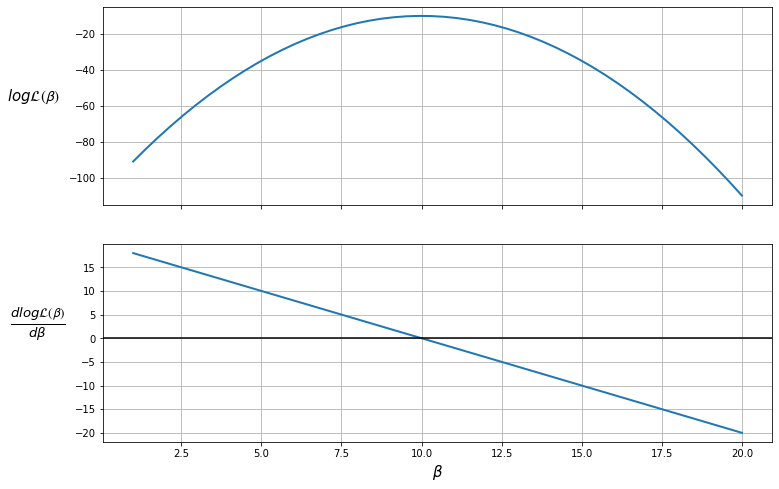

In [8]:
β = np.linspace(1, 20)
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

The plot shows that the maximum likelihood value (the top plot) occurs
when $ \frac{d \log \mathcal{L(\boldsymbol{\beta})}}{d \boldsymbol{\beta}} = 0 $ (the bottom
plot).

Therefore, the likelihood is maximized when $ \beta = 10 $.

We can also ensure that this value is a *maximum* (as opposed to a
minimum) by checking that the second derivative (slope of the bottom
plot) is negative.

The Newton-Raphson algorithm finds a point where the first derivative is
0.

To use the algorithm, we take an initial guess at the maximum value,
$ \beta_0 $ (the OLS parameter estimates might be a reasonable
guess), then

1. Use the updating rule to iterate the algorithm  
  $$
  \boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)} - H^{-1}(\boldsymbol{\beta}_{(k)})G(\boldsymbol{\beta}_{(k)})
  $$
  where:  
  $$
  \begin{aligned}
  G(\boldsymbol{\beta}_{(k)}) = \frac{d \log \mathcal{L(\boldsymbol{\beta}_{(k)})}}{d \boldsymbol{\beta}_{(k)}} \\
  H(\boldsymbol{\beta}_{(k)}) = \frac{d^2 \log \mathcal{L(\boldsymbol{\beta}_{(k)})}}{d \boldsymbol{\beta}_{(k)}d \boldsymbol{\beta}'_{(k)}}
  \end{aligned}
  $$
1. Check whether $ \boldsymbol{\beta}_{(k+1)} - \boldsymbol{\beta}_{(k)} < tol $  
  - If true, then stop iterating and set
    $ \hat{\boldsymbol{\beta}} = \boldsymbol{\beta}_{(k+1)} $  
  - If false, then update $ \boldsymbol{\beta}_{(k+1)} $  


As can be seen from the updating equation,
$ \boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)} $ only when
$ G(\boldsymbol{\beta}_{(k)}) = 0 $ ie. where the first derivative is equal to 0.

(In practice, we stop iterating when the difference is below a small
tolerance threshold)

Let’s have a go at implementing the Newton-Raphson algorithm.

First, we’ll create a class called `PoissonRegression` so we can
easily recompute the values of the log likelihood, gradient and Hessian
for every iteration

In [9]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # Reshape y as a n_by_1 column vector
        self.y = y.reshape(self.n,1)
        # Reshape β as a k_by_1 column vector
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

Our function `newton_raphson` will take a `PoissonRegression` object
that has an initial guess of the parameter vector $ \boldsymbol{\beta}_0 $.

The algorithm will update the parameter vector according to the updating
rule, and recalculate the gradient and Hessian matrices at the new
parameter estimates.

Iteration will end when either:

- The difference between the parameter and the updated parameter is below a tolerance level.  
- The maximum number of iterations has been achieved (meaning convergence is not achieved).  


So we can get an idea of what’s going on while the algorithm is running,
an option `display=True` is added to print out values at each
iteration.

In [10]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G)
        error = β_new - model.β
        model.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β.flatten())]
            update = f'{i:<13}{model.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return model.β.flatten()

Let’s try out our algorithm with a small dataset of 5 observations and 3
variables in $ \mathbf{X} $.

In [11]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 6
β_hat = [-6.07848205  0.93340226  0.84329625]


As this was a simple model with few observations, the algorithm achieved
convergence in only 6 iterations.

You can see that with each iteration, the log-likelihood value increased.

Remember, our objective was to maximize the log-likelihood function,
which the algorithm has worked to achieve.

Also, note that the increase in $ \log \mathcal{L}(\boldsymbol{\beta}_{(k)}) $
becomes smaller with each iteration.

This is because the gradient is approaching 0 as we reach the maximum,
and therefore the numerator in our updating equation is becoming smaller.

The gradient vector should be close to 0 at $ \hat{\boldsymbol{\beta}} $

In [12]:
poi.G()

array([[-3.95169228e-07],
       [-1.00114805e-06],
       [-7.73114562e-07]])

The iterative process can be visualized in the following diagram, where
the maximum is found at $ \beta = 10 $

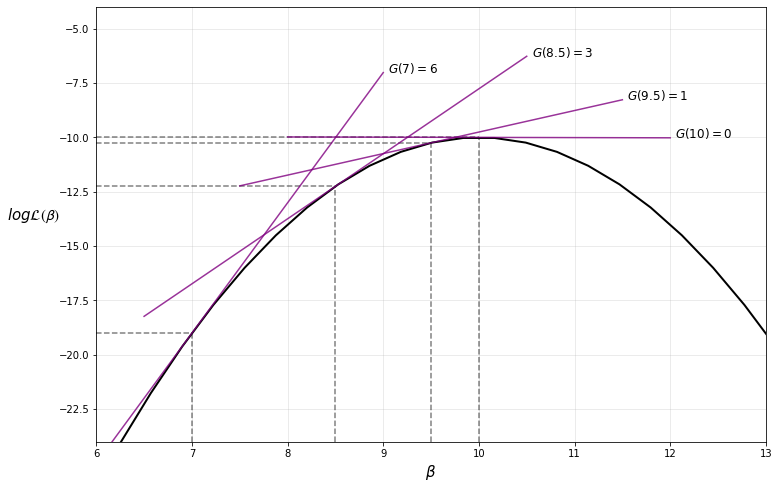

In [13]:
logL = lambda x: -(x - 10) ** 2 - 10

def find_tangent(β, a=0.01):
    y1 = logL(β)
    y2 = logL(β+a)
    x = np.array([[β, 1], [β+a, 1]])
    m, c = np.linalg.lstsq(x, np.array([y1, y2]), rcond=None)[0]
    return m, c

β = np.linspace(2, 18)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(β, logL(β), lw=2, c='black')

for β in [7, 8.5, 9.5, 10]:
    β_line = np.linspace(β-2, β+2)
    m, c = find_tangent(β)
    y = m * β_line + c
    ax.plot(β_line, y, '-', c='purple', alpha=0.8)
    ax.text(β+2.05, y[-1], f'$G({β}) = {abs(m):.0f}$', fontsize=12)
    ax.vlines(β, -24, logL(β), linestyles='--', alpha=0.5)
    ax.hlines(logL(β), 6, β, linestyles='--', alpha=0.5)

ax.set(ylim=(-24, -4), xlim=(6, 13))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=25,
               fontsize=15)
ax.grid(alpha=0.3)
plt.show()

Note that our implementation of the Newton-Raphson algorithm is rather
basic — for more robust implementations see,
for example, [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).

## Maximum Likelihood Estimation with `statsmodels`

Now that we know what’s going on under the hood, we can apply MLE to an interesting application.

We’ll use the Poisson regression model in `statsmodels` to obtain
a richer output with standard errors, test values, and more.

`statsmodels` uses the same algorithm as above to find the maximum
likelihood estimates.

Before we begin, let’s re-estimate our simple model with `statsmodels`
to confirm we obtain the same coefficients and log-likelihood value.

In [14]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Thu, 13 Aug 2020   Pseudo R-squ.:                  0.2546
Time:                        03:56:00   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

Now let’s replicate results from Daniel Treisman’s paper, [Russia’s
Billionaires](http://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068),
mentioned earlier in the lecture.

Treisman starts by estimating equation [(1)](#equation-poissonreg), where:

- $ y_i $ is $ {number\ of\ billionaires}_i $  
- $ x_{i1} $ is $ \log{GDP\ per\ capita}_i $  
- $ x_{i2} $ is $ \log{population}_i $  
- $ x_{i3} $ is $ {years\ in\ GATT}_i $ – years membership in GATT and WTO (to proxy access to international markets)  


The paper only considers the year 2008 for estimation.

We will set up our variables for estimation like so (you should have the
data assigned to `df` from earlier in the lecture)

In [15]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

Then we can use the `Poisson` function from `statsmodels` to fit the
model.

We’ll use robust standard errors as in the author’s paper

In [16]:
# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Thu, 13 Aug 2020   Pseudo R-squ.:                  0.8574
Time:                        03:56:01   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

Success! The algorithm was able to achieve convergence in 9 iterations.

Our output indicates that GDP per capita, population, and years of
membership in the General Agreement on Tariffs and Trade (GATT) are
positively related to the number of billionaires a country has, as
expected.

Let’s also estimate the author’s more full-featured models and display
them in a single table

In [17]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires \
                        in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw              

The output suggests that the frequency of billionaires is positively
correlated with GDP per capita, population size, stock market
capitalization, and negatively correlated with top marginal income tax
rate.

To analyze our results by country, we can plot the difference between
the predicted an actual values, then sort from highest to lowest and
plot the first 15

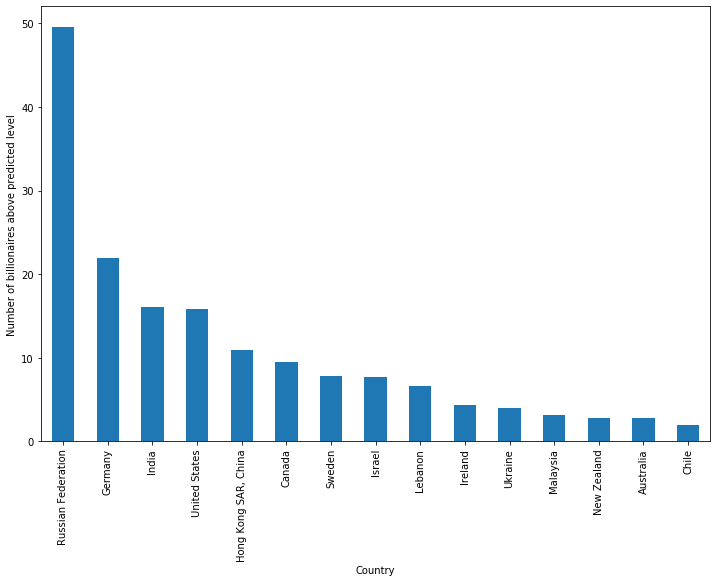

In [18]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

As we can see, Russia has by far the highest number of billionaires in
excess of what is predicted by the model (around 50 more than expected).

Treisman uses this empirical result to discuss possible reasons for
Russia’s excess of billionaires, including the origination of wealth in
Russia, the political climate, and the history of privatization in the
years after the USSR.

## Summary

In this lecture, we used Maximum Likelihood Estimation to estimate the
parameters of a Poisson model.

`statsmodels` contains other built-in likelihood models such as
[Probit](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Probit.html)
and
[Logit](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html).

For further flexibility, `statsmodels` provides a way to specify the
distribution manually using the `GenericLikelihoodModel` class - an
example notebook can be found
[here](http://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html).

## Exercises

### Exercise 1

Suppose we wanted to estimate the probability of an event $ y_i $
occurring, given some observations.

We could use a probit regression model, where the pmf of $ y_i $ is

$$
\begin{aligned}
f(y_i; \boldsymbol{\beta}) = \mu_i^{y_i} (1-\mu_i)^{1-y_i}, \quad y_i = 0,1 \\
\text{where} \quad \mu_i = \Phi(\mathbf{x}_i' \boldsymbol{\beta})
\end{aligned}
$$

$ \Phi $ represents the *cumulative normal distribution* and
constrains the predicted $ y_i $ to be between 0 and 1 (as required
for a probability).

$ \boldsymbol{\beta} $ is a vector of coefficients.

Following the example in the lecture, write a class to represent the
Probit model.

To begin, find the log-likelihood function and derive the gradient and
Hessian.

The `scipy` module `stats.norm` contains the functions needed to
compute the cmf and pmf of the normal distribution.

In [219]:
class myProbit:
    
    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        self.y = y
        self.β = β
        
    def μ(self):
        return norm.cdf(self.X @ self.β)

    def logL(self):
        μ = self.μ()
        y = self.y
        return np.sum(y * np.log(μ) + (1 - y) * np.log(1 - μ))
    
    def ϕ(self):
        β = self.β
        X = self.X
        return norm.pdf(X @ β)

    def G(self):
        μ = self.μ()
        ϕ = self.ϕ()
        y = self.y
        X = self.X
        part_1 = y * (X.T * ϕ / μ)
        part_2 = (1 - y) * (X.T * ϕ / (1 - μ))
        return np.sum(part_1 - part_2, axis=1)

    def H(self):
        μ = self.μ()
        ϕ = self.ϕ()
        y = self.y
        X = self.X
        β = self.β
        
        part_1 = (ϕ + (X @ β.T) * μ) / μ ** 2
        part_2 = (ϕ - (X @ β.T) * (1 - μ)) / (1 - μ) ** 2

        return - (ϕ * (y * part_1 + (1 - y) * part_2) * X.T) @ X

### Exercise 2

Use the following dataset and initial values of $ \boldsymbol{\beta} $ to
estimate the MLE with the Newton-Raphson algorithm developed earlier in
the lecture

$$
\mathbf{X} =
\begin{bmatrix}
1 & 2 & 4 \\
1 & 1 & 1 \\
1 & 4 & 3 \\
1 & 5 & 6 \\
1 & 3 & 5
\end{bmatrix}
\quad
y =
\begin{bmatrix}
1 \\
0 \\
1 \\
1 \\
0
\end{bmatrix}
\quad
\boldsymbol{\beta}_{(0)} =
\begin{bmatrix}
0.1 \\
0.1 \\
0.1
\end{bmatrix}
$$

Verify your results with `statsmodels` - you can import the Probit
function with the following import statement

In [220]:
from statsmodels.discrete.discrete_model import Probit

X = np.array([[1, 2, 4],
              [1, 1, 1],
              [1, 4, 3],
              [1, 5, 6],
              [1, 3, 5]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
β0 = np.array([0.1, 0.1, 0.1])

# Create instance of Probit regression class
prob = myProbit(y, X, β0)

# Run Newton-Raphson algorithm
newton_raphson(prob)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -2.3796884      ['-1.34', '0.775', '-0.157']
1            -2.3687526      ['-1.53', '0.775', '-0.0981']
2            -2.3687294      ['-1.55', '0.778', '-0.0971']
3            -2.3687294      ['-1.55', '0.778', '-0.0971']
Number of iterations: 4
β_hat = [-1.54625858  0.77778952 -0.09709757]


array([-1.54625858,  0.77778952, -0.09709757])

Note that the simple Newton-Raphson algorithm developed in this lecture
is very sensitive to initial values, and therefore you may fail to
achieve convergence with different starting values.

In [235]:
# Initial value that fails:
# Take a guess at initial βs
β0 = np.random.rand(3)
print("β0:", β0)

# Create instance of Probit regression class
prob = myProbit(y, X, β0)

# Run Newton-Raphson algorithm
newton_raphson(prob)

β0: [0.11704749 0.99157466 0.79738141]
Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            nan             ['nan', 'nan', 'nan']
Number of iterations: 1
β_hat = [nan nan nan]


/Users/ohyeah/.virtualenvs/base/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/ohyeah/.virtualenvs/base/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply
/Users/ohyeah/.virtualenvs/base/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/ohyeah/.virtualenvs/base/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
/Users/ohyeah/.virtualenvs/base/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


array([nan, nan, nan])

## Solutions

### Exercise 1

The log-likelihood can be written as

$$
\log \mathcal{L} = \sum_{i=1}^n
\big[
y_i \log \Phi(\mathbf{x}_i' \boldsymbol{\beta}) +
(1 - y_i) \log (1 - \Phi(\mathbf{x}_i' \boldsymbol{\beta})) \big]
$$

Using the **fundamental theorem of calculus**, the derivative of a
cumulative probability distribution is its marginal distribution

$$
\frac{ \partial} {\partial s} \Phi(s) = \phi(s)
$$

where $ \phi $ is the marginal normal distribution.

The gradient vector of the Probit model is

$$
\frac {\partial \log \mathcal{L}} {\partial \boldsymbol{\beta}} =
\sum_{i=1}^n \Big[
y_i \frac{\phi(\mathbf{x}'_i \boldsymbol{\beta})}{\Phi(\mathbf{x}'_i \boldsymbol{\beta)}} -
(1 - y_i) \frac{\phi(\mathbf{x}'_i \boldsymbol{\beta)}}{1 - \Phi(\mathbf{x}'_i \boldsymbol{\beta)}}
\Big] \mathbf{x}_i
$$

The Hessian of the Probit model is

$$
\frac {\partial^2 \log \mathcal{L}} {\partial \boldsymbol{\beta} \partial \boldsymbol{\beta}'} =
- \sum_{i=1}^n \phi (\mathbf{x}_i' \boldsymbol{\beta})
\Big[
y_i \frac{ \phi (\mathbf{x}_i' \boldsymbol{\beta}) + \mathbf{x}_i' \boldsymbol{\beta} \Phi (\mathbf{x}_i' \boldsymbol{\beta}) } { [\Phi (\mathbf{x}_i' \boldsymbol{\beta})]^2 } +
(1 - y_i) \frac{ \phi_i (\mathbf{x}_i' \boldsymbol{\beta}) - \mathbf{x}_i' \boldsymbol{\beta} (1 - \Phi (\mathbf{x}_i' \boldsymbol{\beta})) } { [1 - \Phi (\mathbf{x}_i' \boldsymbol{\beta})]^2 }
\Big]
\mathbf{x}_i \mathbf{x}_i'
$$

Using these results, we can write a class for the Probit model as
follows

In [213]:
class ProbitRegression:

    def __init__(self, y, X, β):
        self.X, self.y, self.β = X, y, β
        self.n, self.k = X.shape

    def μ(self):
        return norm.cdf(self.X @ self.β.T)

    def ϕ(self):
        return norm.pdf(self.X @ self.β.T)

    def logL(self):
        μ = self.μ()
        return np.sum(y * np.log(μ) + (1 - y) * np.log(1 - μ))

    def G(self):
        μ = self.μ()
        ϕ = self.ϕ()
        return np.sum((X.T * y * ϕ / μ - X.T * (1 - y) * ϕ / (1 - μ)),
                     axis=1)

    def H(self):
        X = self.X
        β = self.β
        μ = self.μ()
        ϕ = self.ϕ()
        a = (ϕ + (X @ β.T) * μ) / μ**2
        b = (ϕ - (X @ β.T) * (1 - μ)) / (1 - μ)**2

        return -(ϕ * (y * a + (1 - y) * b) * X.T) @ X

### Exercise 2

In [214]:
X = np.array([[1, 2, 4],
              [1, 1, 1],
              [1, 4, 3],
              [1, 5, 6],
              [1, 3, 5]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
β = np.array([0.1, 0.1, 0.1])

# Create instance of Probit regression class
prob = ProbitRegression(y, X, β)

# Run Newton-Raphson algorithm
newton_raphson(prob)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -2.3796884      ['-1.34', '0.775', '-0.157']
1            -2.3687526      ['-1.53', '0.775', '-0.0981']
2            -2.3687294      ['-1.55', '0.778', '-0.0971']
3            -2.3687294      ['-1.55', '0.778', '-0.0971']
Number of iterations: 4
β_hat = [-1.54625858  0.77778952 -0.09709757]


array([-1.54625858,  0.77778952, -0.09709757])

In [ ]:
# Use statsmodels to verify results

print(Probit(y, X).fit().summary())